# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

## Data ingestion

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mitchellharrison/my-first-1000-valorant-games")

print("Path to dataset files:", path)

100%|██████████| 19.1k/19.1k [00:00<00:00, 25.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mitchellharrison/my-first-1000-valorant-games/versions/1


In [17]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/creditcard.csv')
df = pd.read_csv(path + '/valorant_games.csv');

In [18]:
df = df[df['outcome'] != 'Draw']

In [5]:
#df = df.drop(columns=['round_wins', 'round_losses', 'game_id', 'date'])

## Data exploration

In [5]:
df.head(5)

,game_id,episode,act,rank,date,agent,map,outcome,round_wins,round_losses,kills,deaths,assists,kdr,avg_dmg_delta,headshot_pct,avg_dmg,acs,num_frag
0,1,6,2,Placement,4/11/2023,Cypher,Ascent,Loss,5,13,8,15,4,0.5,-61,3,76,125,3
1,2,6,2,Placement,4/12/2023,Cypher,Icebox,Loss,4,13,3,15,2,0.2,-124,22,42,59,5
2,3,6,2,Placement,4/15/2023,KAY/O,Lotus,Win,13,4,7,12,7,0.6,-46,2,87,132,5
3,4,6,2,Placement,4/15/2023,Brimstone,Ascent,Loss,9,13,18,12,10,1.5,23,14,137,230,2
4,5,6,2,Placement,4/15/2023,Cypher,Haven,Loss,1,13,6,14,3,0.4,-75,7,90,146,4


In [6]:
df.shape

(988, 19)

In [7]:
df.describe()

,game_id,episode,act,round_wins,round_losses,kills,deaths,assists,kdr,avg_dmg_delta,headshot_pct,avg_dmg,acs,num_frag
count,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000
mean,500.974696,7.500000,2.067814,10.539474,10.476721,15.211538,14.182186,4.628543,1.178644,10.317814,22.783401,134.408907,205.287449,2.990891
std,288.436695,1.100336,0.869648,3.349524,3.544258,5.179336,3.692761,2.650663,0.659956,43.542945,9.933704,35.257064,56.576103,1.366452
min,1.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.200000,-124.000000,2.000000,42.000000,59.000000,1.000000
25%,251.750000,7.000000,1.000000,8.000000,8.000000,12.000000,12.750000,3.000000,0.800000,-20.250000,15.000000,110.000000,166.000000,2.000000
50%,500.500000,7.000000,2.000000,13.000000,13.000000,15.000000,15.000000,4.000000,1.100000,10.000000,22.000000,133.000000,203.000000,3.000000
75%,750.250000,9.000000,3.000000,13.000000,13.000000,19.000000,17.000000,6.000000,1.400000,39.000000,29.000000,157.000000,240.000000,4.000000
max,1000.000000,9.000000,3.000000,18.000000,20.000000,34.000000,26.000000,20.000000,9.700000,293.000000,63.000000,373.000000,572.000000,5.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 0 to 999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        988 non-null    int64  
 1   episode        988 non-null    int64  
 2   act            988 non-null    int64  
 3   rank           988 non-null    object 
 4   date           988 non-null    object 
 5   agent          988 non-null    object 
 6   map            988 non-null    object 
 7   outcome        988 non-null    object 
 8   round_wins     988 non-null    int64  
 9   round_losses   988 non-null    int64  
 10  kills          988 non-null    int64  
 11  deaths         988 non-null    int64  
 12  assists        988 non-null    int64  
 13  kdr            988 non-null    float64
 14  avg_dmg_delta  988 non-null    int64  
 15  headshot_pct   988 non-null    int64  
 16  avg_dmg        988 non-null    int64  
 17  acs            988 non-null    int64  
 18  num_frag       

## Ести ли пропуски?

In [9]:
df.isnull().values.any()

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [10]:
df['outcome'].value_counts()

,count
outcome,
Loss,497
Win,491


In [11]:
LABELS = ["Loss", "Win"]

<ipython-input-12-58d6e109370a>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['outcome'], sort = True)


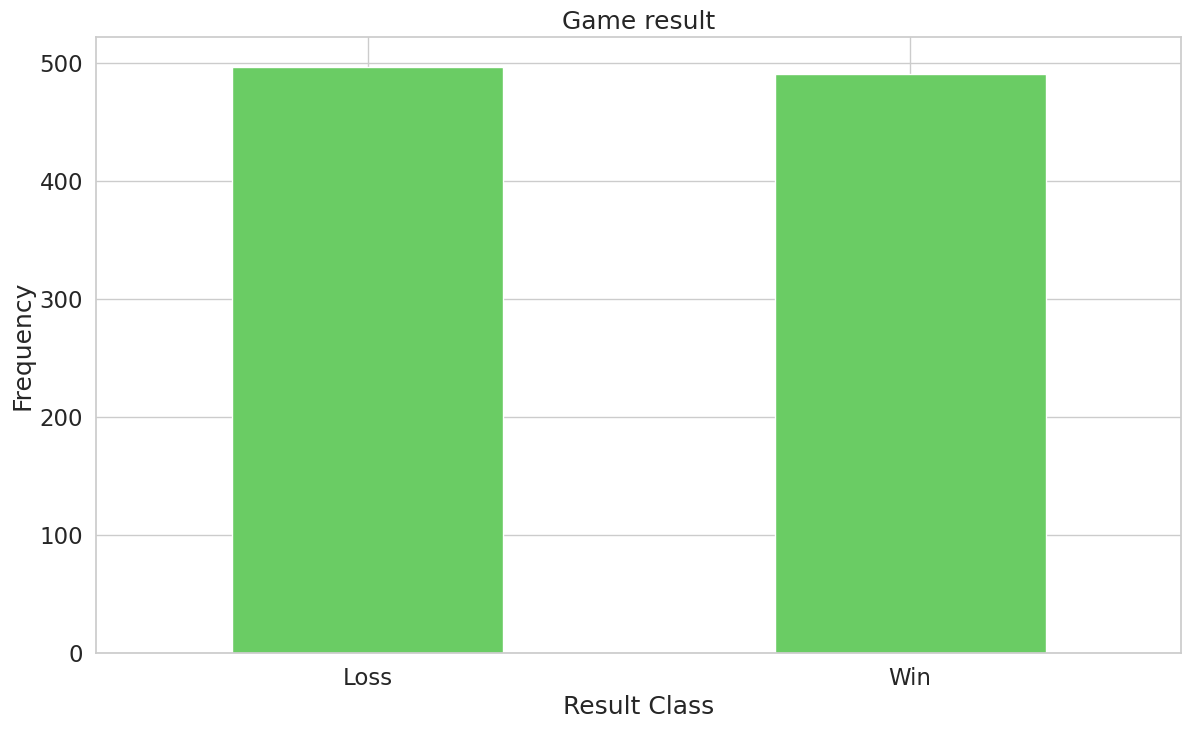

In [12]:
count_classes = pd.value_counts(df['outcome'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Game result")
plt.xticks(range(2), LABELS)
plt.xlabel("Result Class")
plt.ylabel("Frequency");

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['outcome'] = label_encoder.fit_transform(df['outcome'])
df['rank'] = label_encoder.fit_transform(df['rank'])
df['agent'] = label_encoder.fit_transform(df['agent'])
df['map'] = label_encoder.fit_transform(df['map'])

In [20]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y').dt.strftime('%Y%m%d').astype(int)

In [22]:
df.head()

,game_id,episode,act,rank,date,agent,map,outcome,round_wins,round_losses,kills,deaths,assists,kdr,avg_dmg_delta,headshot_pct,avg_dmg,acs,num_frag
0,1,6,2,8,20230411,3,1,0,5,13,8,15,4,0.5,-61,3,76,125,3
1,2,6,2,8,20230412,3,6,0,4,13,3,15,2,0.2,-124,22,42,59,5
2,3,6,2,8,20230415,5,7,1,13,4,7,12,7,0.6,-46,2,87,132,5
3,4,6,2,8,20230415,2,1,0,9,13,18,12,10,1.5,23,14,137,230,2
4,5,6,2,8,20230415,3,5,0,1,13,6,14,3,0.4,-75,7,90,146,4


In [21]:
df['outcome'].value_counts()

,count
outcome,
0,497
1,491


Наш набор данных хорошо сбалансирован


In [23]:
lossDF = df[df.outcome == 1]
winDF = df[df.outcome == 0]

In [24]:
lossDF.shape

(491, 19)

In [25]:
winDF.shape

(497, 19)

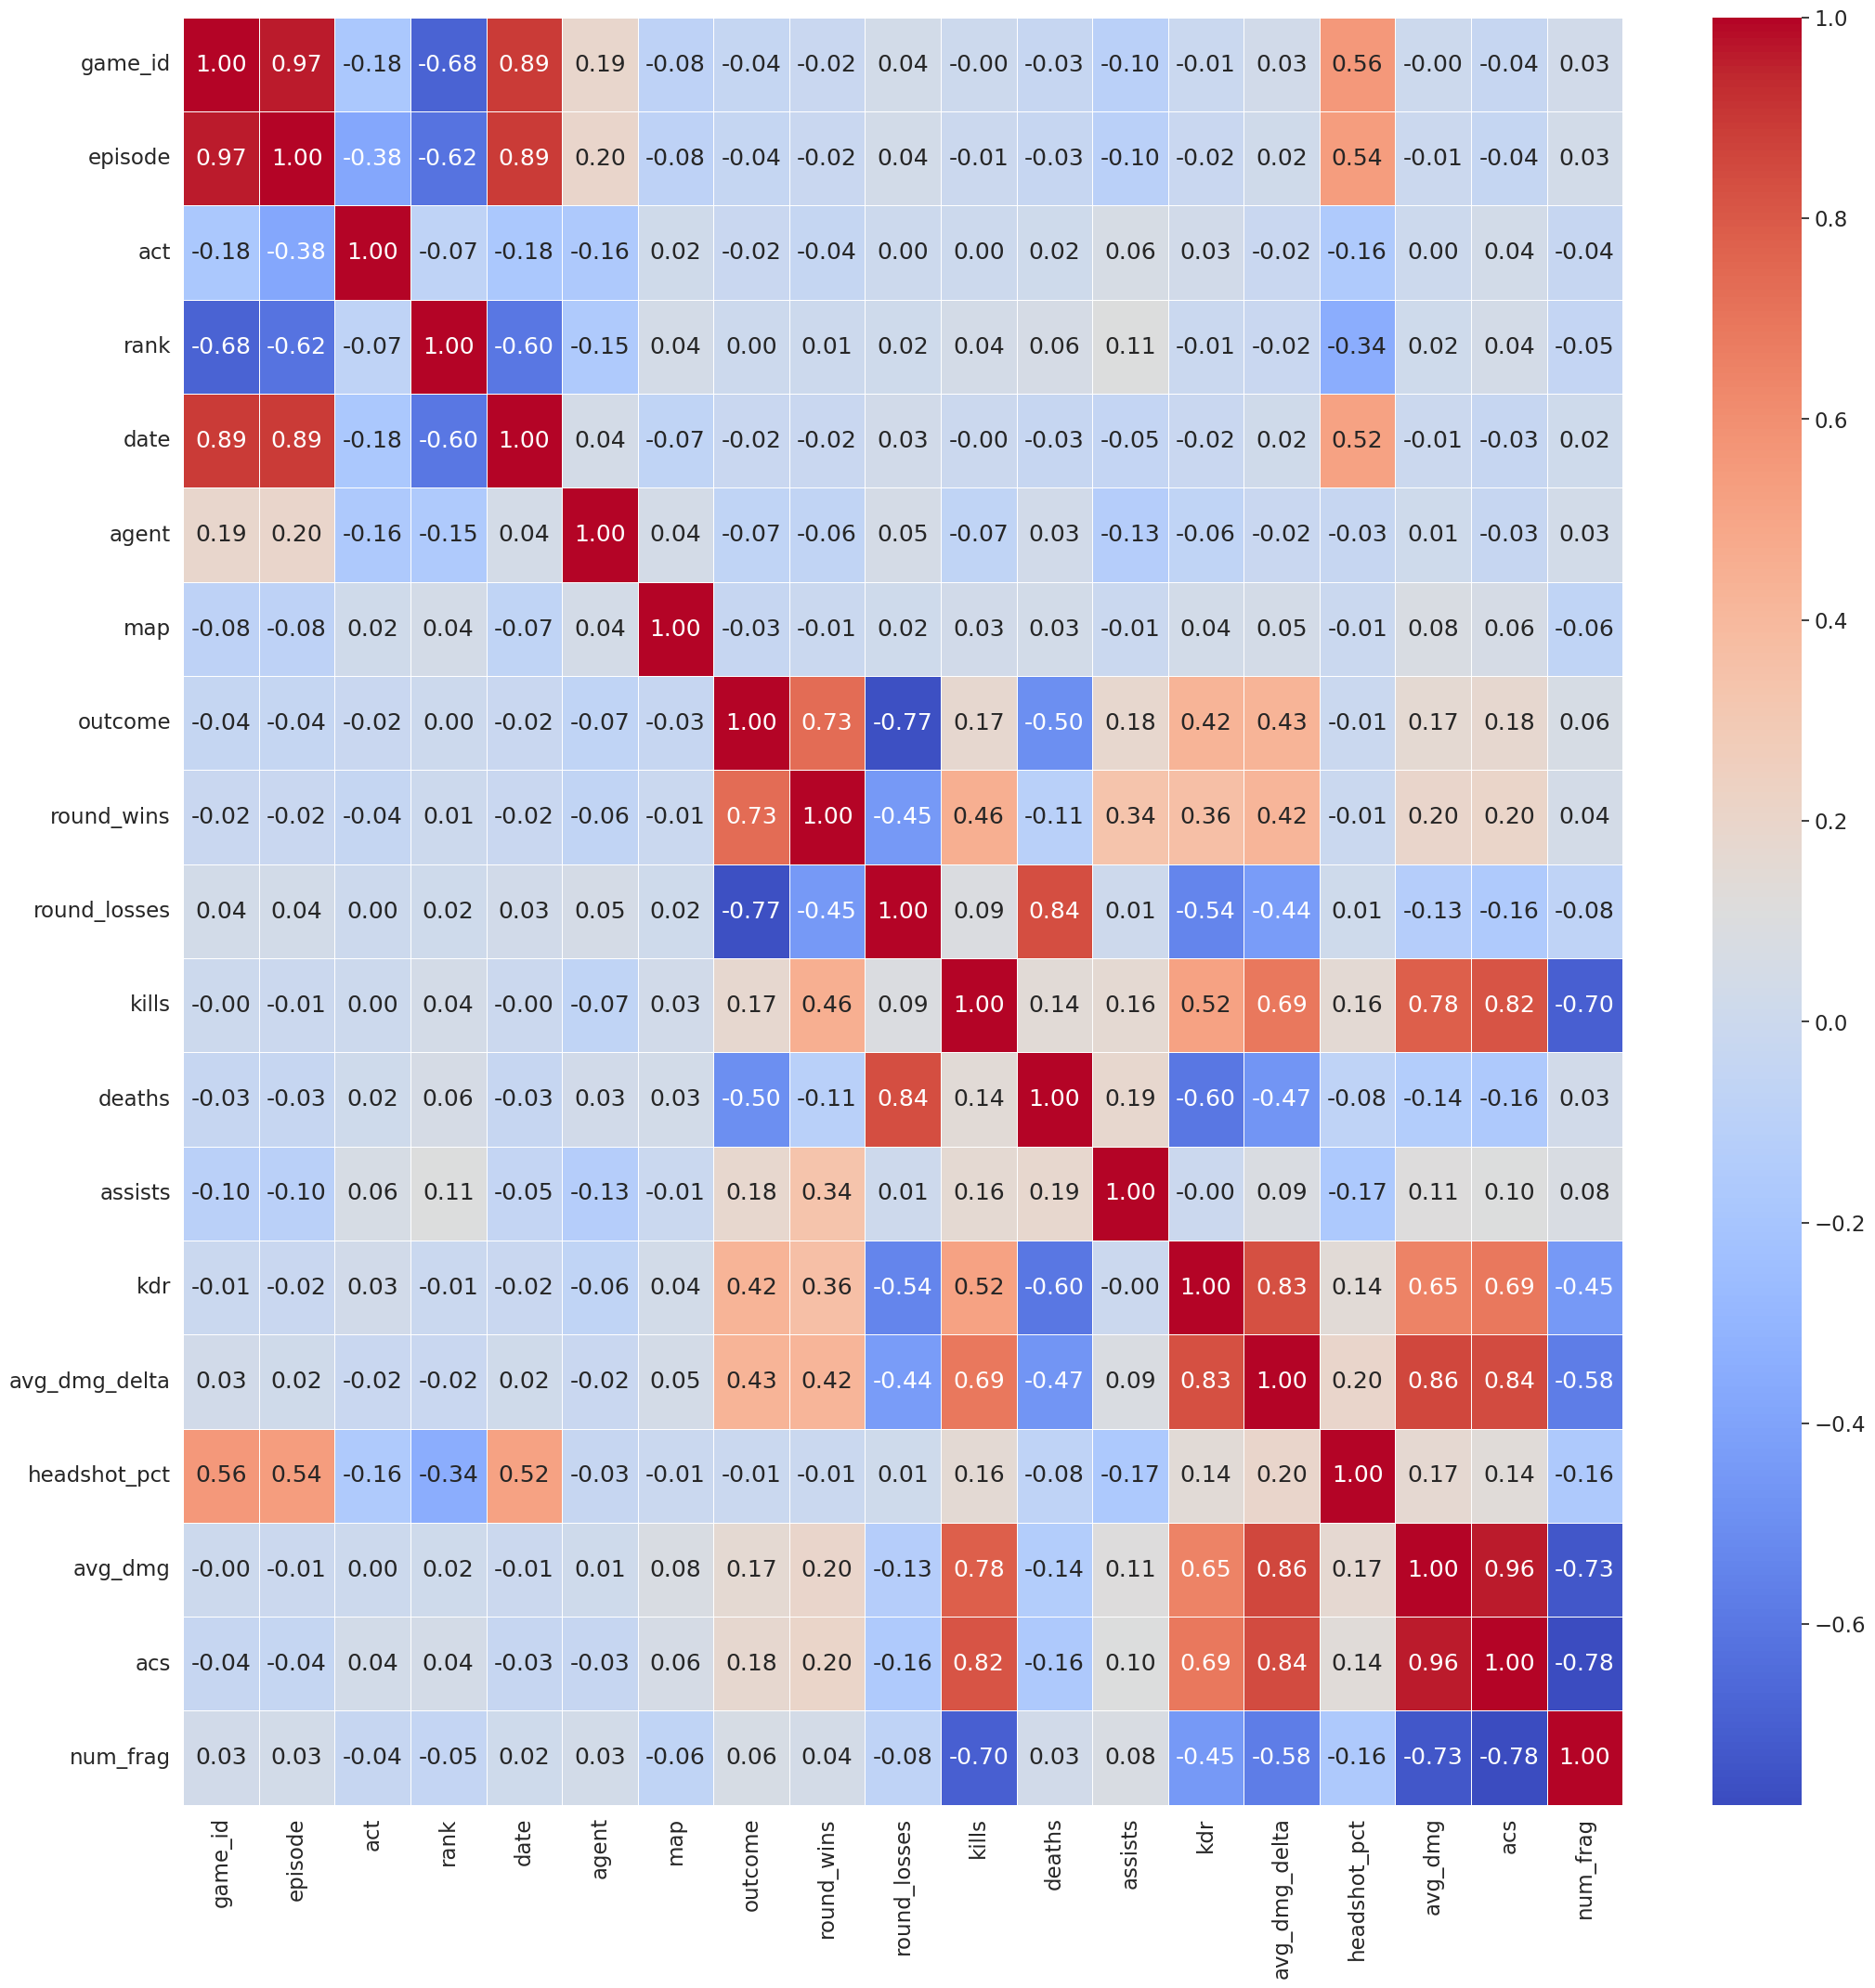

In [27]:
# Вычисление матрицы корреляции
correlation_matrix = df.corr()

# Построение heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

## Preprocessing

In [91]:
correlation_with_level = correlation_matrix['outcome']  # Корреляции с Level

# Отбор параметров с корреляцией >= 0.5 по модулю
selected_features = correlation_with_level[correlation_with_level.abs() > 0.1].index

# Создание нового DataFrame с отобранными параметрами
gameData = df[selected_features]
#gameData = df

In [92]:
gameData.shape

(988, 10)

In [93]:
gameData = gameData.drop(columns=['avg_dmg'])

In [94]:
gameData.head(5)

,outcome,round_wins,round_losses,kills,deaths,assists,kdr,avg_dmg_delta,acs
0,0,5,13,8,15,4,0.5,-61,125
1,0,4,13,3,15,2,0.2,-124,59
2,1,13,4,7,12,7,0.6,-46,132
3,0,9,13,18,12,10,1.5,23,230
4,0,1,13,6,14,3,0.4,-75,146


In [95]:
#gameData['headshot_pct'] = StandardScaler().fit_transform(gameData['headshot_pct'].values.reshape(-1, 1))
gameData['acs'] = StandardScaler().fit_transform(gameData['acs'].values.reshape(-1, 1))
gameData['round_wins'] = StandardScaler().fit_transform(gameData['round_wins'].values.reshape(-1, 1))
gameData['round_losses'] = StandardScaler().fit_transform(gameData['round_losses'].values.reshape(-1, 1))
#gameData['avg_dmg'] = StandardScaler().fit_transform(gameData['avg_dmg'].values.reshape(-1, 1))
gameData['kills'] = StandardScaler().fit_transform(gameData['kills'].values.reshape(-1, 1))
gameData['deaths'] = StandardScaler().fit_transform(gameData['deaths'].values.reshape(-1, 1))
gameData['assists'] = StandardScaler().fit_transform(gameData['assists'].values.reshape(-1, 1))
gameData['avg_dmg_delta'] = StandardScaler().fit_transform(gameData['avg_dmg_delta'].values.reshape(-1, 1))
#gameData['date'] = StandardScaler().fit_transform(gameData['date'].values.reshape(-1, 1))

In [81]:
gameData.shape

(988, 9)

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только записи с риском рака менее высокого, а в тестовом наборе данных будут все

In [96]:
X_train, X_test = train_test_split(gameData, test_size=0.2, random_state=RANDOM_SEED)
X_test
X_train = X_train[X_train.outcome == 0]
X_train = X_train.drop(['outcome'], axis=1)
#print(type(X_train))
y_test = X_test['outcome']
X_test = X_test.drop(['outcome'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values

print(y_test.size)


198


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,29 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 29 узлов, соответствующих 29 функциям в элементе входных данных.

In [97]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(8, 4),
            nn.ELU(),
            nn.Linear(4, 2),
            nn.LeakyReLU()
            )

        self.decoder = nn.Sequential(
            nn.Linear(2, 2),
            nn.ELU(),
            nn.Linear(2, 8),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




In [99]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [100]:
num_epochs = 300   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

In [101]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [102]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [103]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4  # Меньшее значение регуляризации для улучшения обобщения
)

# optimizer = torch.optim.Adam(
# model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [104]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [105]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        data = data
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/300], loss:0.9690
epoch [2/300], loss:0.9449
epoch [3/300], loss:0.9201
epoch [4/300], loss:0.9050
epoch [5/300], loss:0.8713
epoch [6/300], loss:0.8534
epoch [7/300], loss:0.8494
epoch [8/300], loss:0.8393
epoch [9/300], loss:0.8498
epoch [10/300], loss:0.8028
epoch [11/300], loss:0.8196
epoch [12/300], loss:0.7997
epoch [13/300], loss:0.7915
epoch [14/300], loss:0.8386
epoch [15/300], loss:0.7740
epoch [16/300], loss:0.7668
epoch [17/300], loss:0.7663
epoch [18/300], loss:0.7482
epoch [19/300], loss:0.7580
epoch [20/300], loss:0.7731
epoch [21/300], loss:0.7603
epoch [22/300], loss:0.7681
epoch [23/300], loss:0.7687
epoch [24/300], loss:0.7644
epoch [25/300], loss:0.7365
epoch [26/300], loss:0.7251
epoch [27/300], loss:0.7096
epoch [28/300], loss:0.6856
epoch [29/300], loss:0.6694
epoch [30/300], loss:0.6778
epoch [31/300], loss:0.6710
epoch [32/300], loss:0.6591
epoch [33/300], loss:0.6510
epoch [34/300], loss:0.6390
epoch [35/300], loss:0.6904
epoch [36/300], loss:0.6502
e

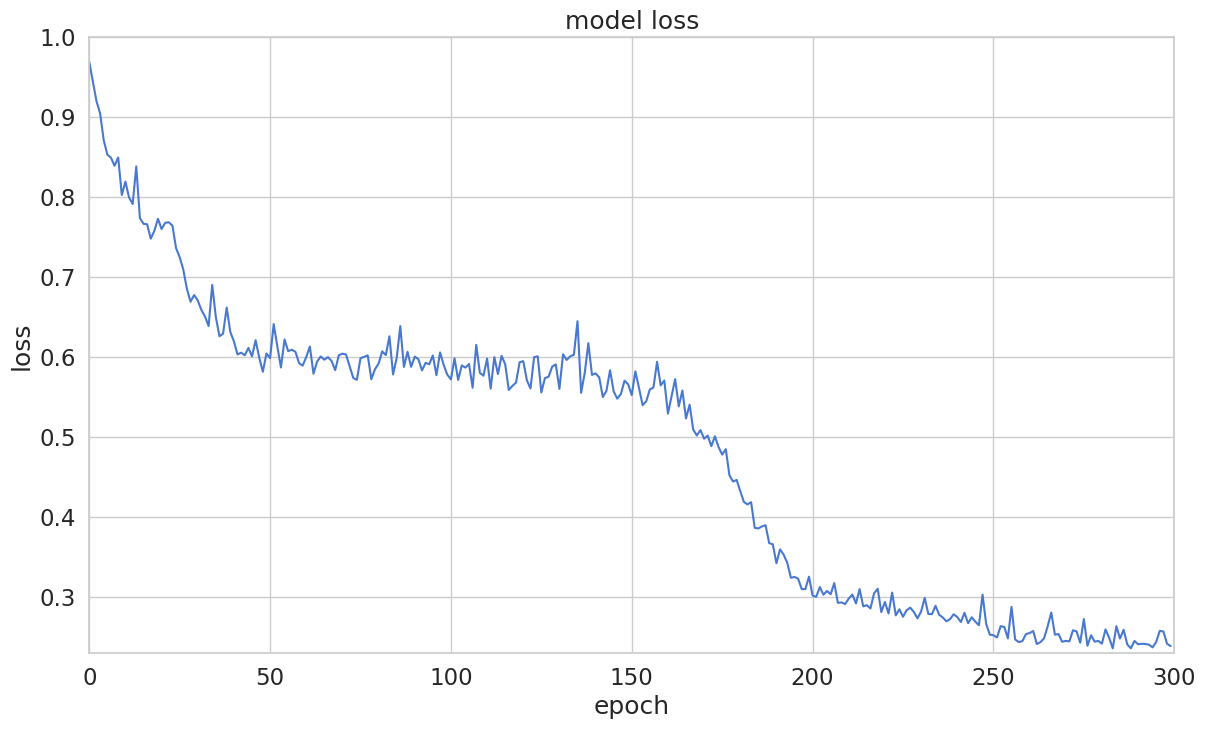

In [106]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,300,0.23,1])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [107]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data.double()
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [108]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,198.000000,198.000000
mean,0.600240,0.449495
std,0.710910,0.498704
min,0.013341,0.000000
25%,0.168133,0.000000
50%,0.375500,0.000000
75%,0.715935,1.000000
max,5.636933,1.000000


In [109]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,198.000000,198.000000
mean,0.600240,0.449495
std,0.710910,0.498704
min,0.013341,0.000000
25%,0.168133,0.000000
50%,0.375500,0.000000
75%,0.715935,1.000000
max,5.636933,1.000000


# Reconstruction Errors without Fraud

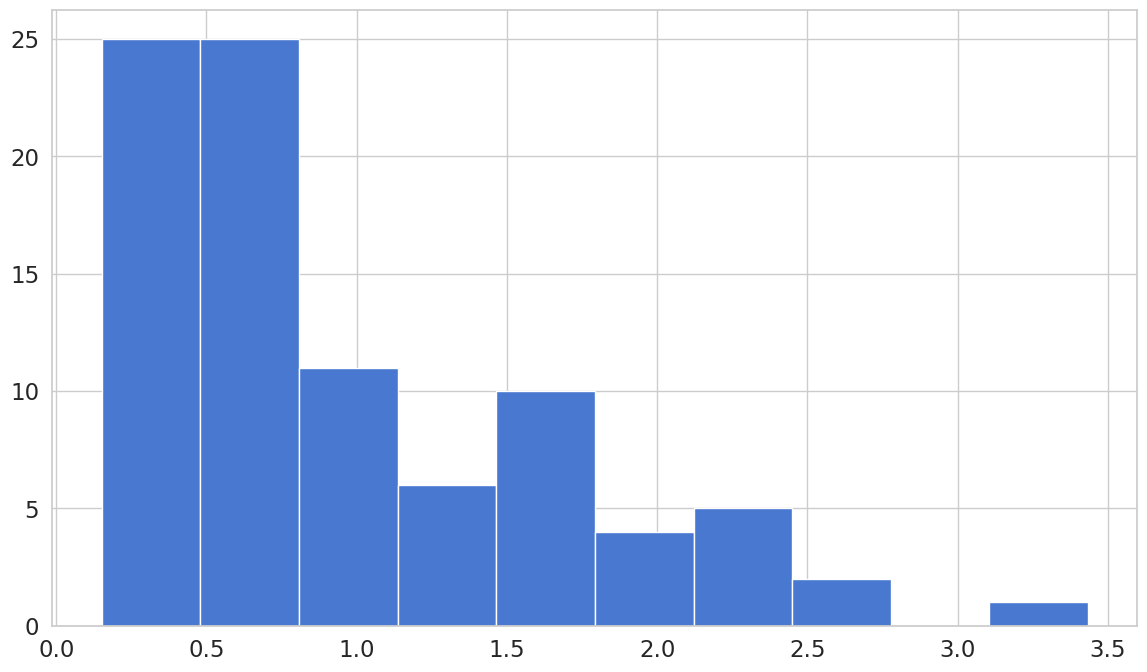

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) & (reconstructionErrorDF['pred_loss'] < 40)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

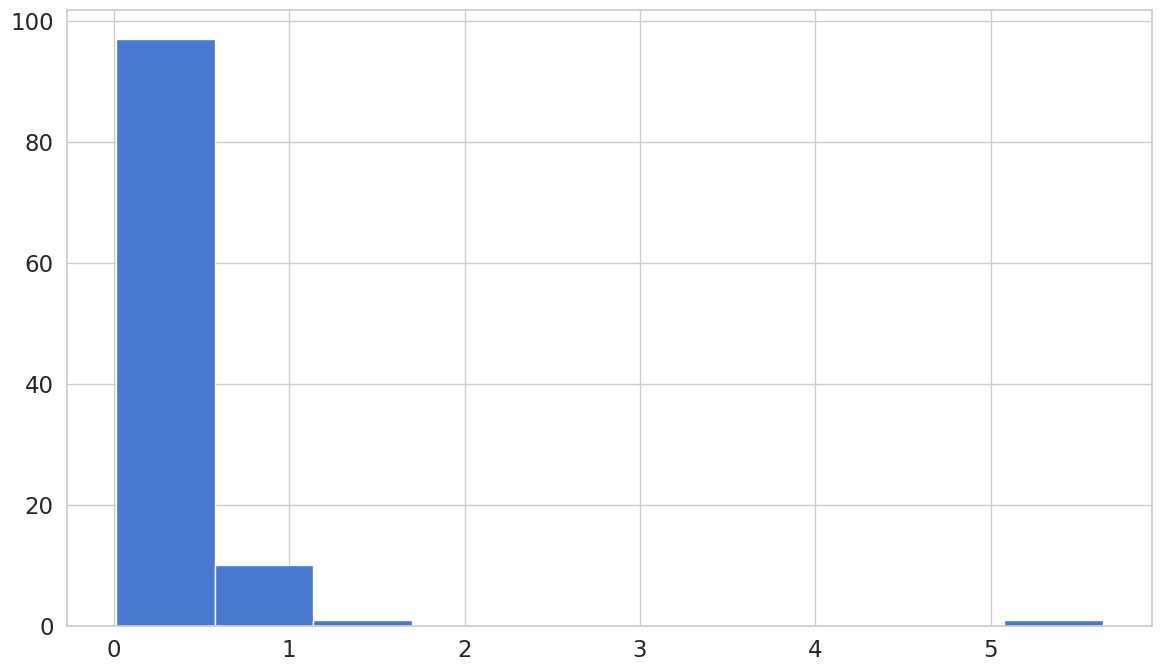

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

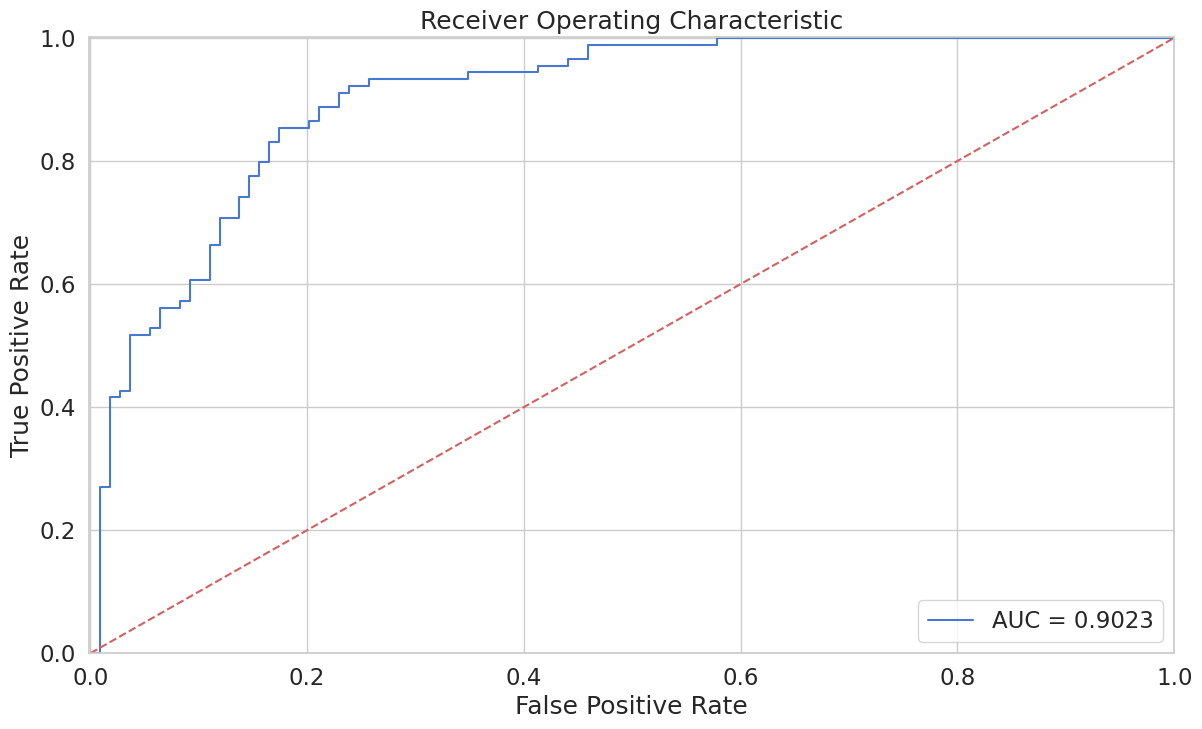

In [112]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

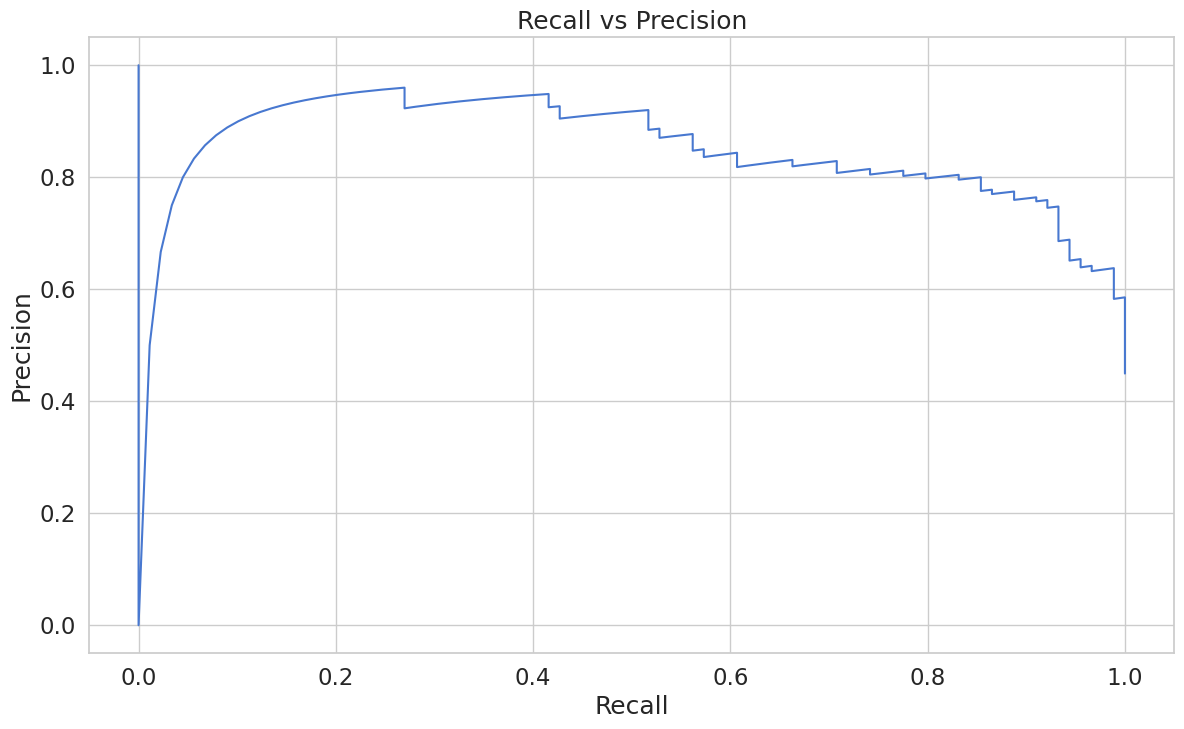

In [113]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

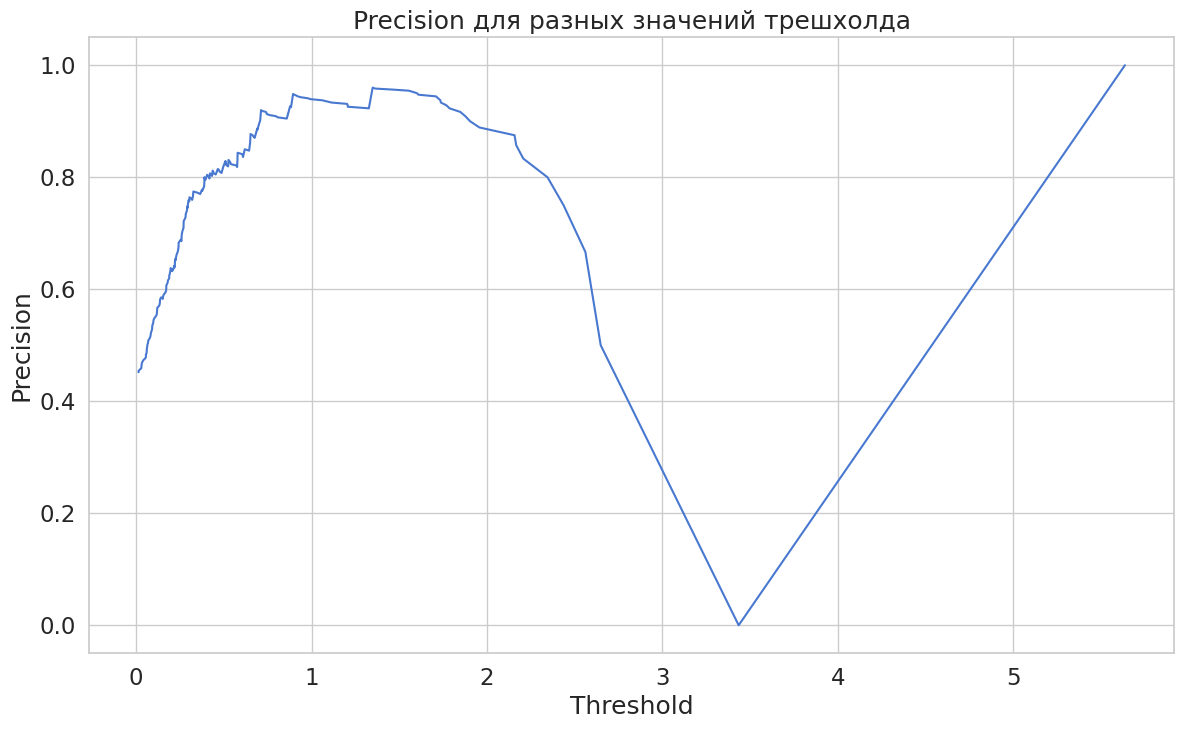

In [114]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


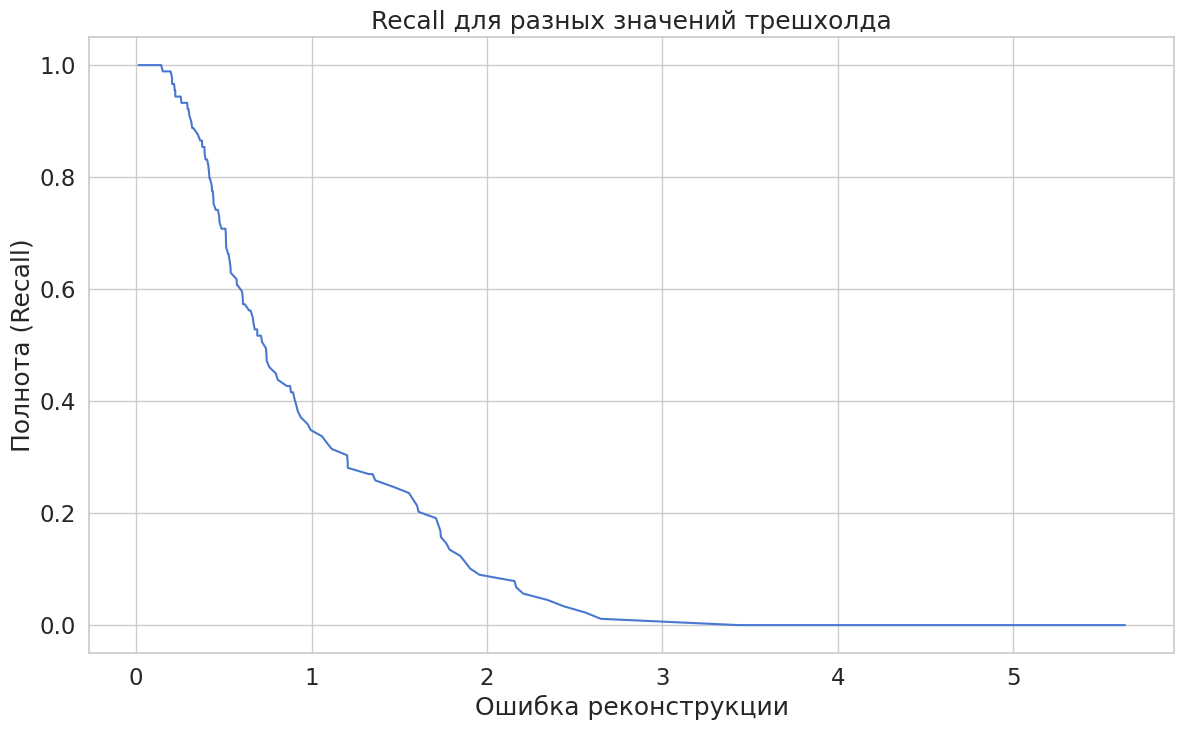

In [115]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [123]:
threshold = 0.4

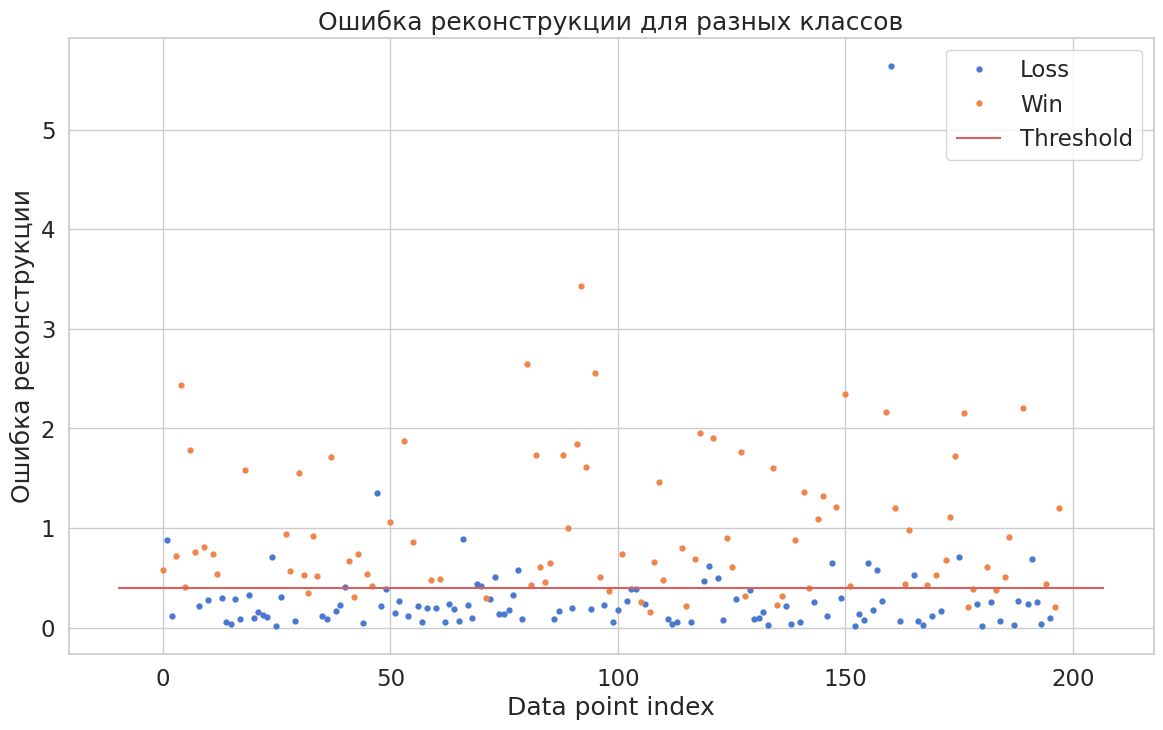

In [124]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Win" if name == 1 else "Loss")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-125-11f70cc5c840>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


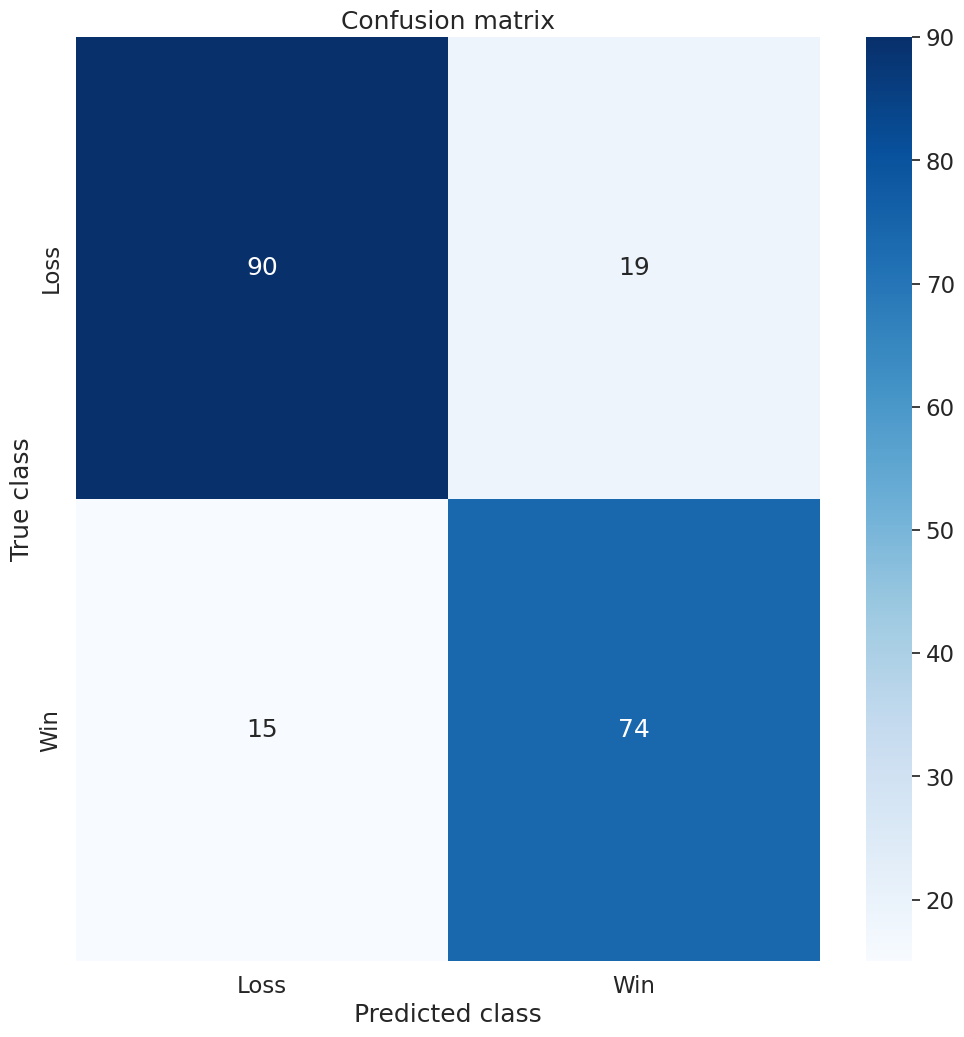

In [125]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество случаев мошенничества. Но количество обычных транзакций, классифицируемых как мошенничество, действительно велико. Можно настроить порог здесь и там, чтобы получить лучшие результаты.

## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.